### 1. Importing dependencies and defining useful functions.

In [1]:
import numpy as np
import os
from pathlib import Path
import pandas as pd
import seaborn as sns
import PIL
import tensorflow as tf
from sklearn.cluster import KMeans
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from keras.applications.imagenet_utils import decode_predictions
import matplotlib.pyplot as plt

In [2]:
# set the images according to the ResNet50 input shape
def pre_process_images(dict_imgs):
    dict_pp = {breeds[0]: [], breeds[1]: [], breeds[2]: [], breeds[3]: []}
    for breed in dict_pp:
        for i, img in enumerate(dict_imgs[breed]):
            img = image.img_to_array(img)
            img = np.expand_dims(img, axis=0)
            img = preprocess_input(img)
            dict_pp[breed].append(img)

    return dict_pp

In [3]:
# set the images according to the sklearn K-Means input shape
def pre_process_compression():
    original_ppc = {breeds[0]: [], breeds[1]: [], breeds[2]: [], breeds[3]: []}
    for breed in breeds:
        for img in original[breed]:
            img = image.img_to_array(img)
            img = img.reshape(224*224, 3)
            original_ppc[breed].append(img)
    return original_ppc

In [4]:
# applies K-Means to the input image in order to compress it
def compress_imgs_kmeans(K):
    k_compressed_imgs = {breeds[0]: [], breeds[1]: [], breeds[2]: [], breeds[3]: []}
    kmeans = KMeans(n_clusters=K, n_init='auto')
    for breed in breeds:
        for img in original_ppc[breed]:
            kmeans.fit(img)
            compressed_img = kmeans.cluster_centers_[kmeans.labels_]
            compressed_img = np.clip(compressed_img.astype('uint8'), 0, 255)
            
            # Reshape the image to original dimension
            compressed_img = compressed_img.reshape(224, 224, 3)
            k_compressed_imgs[breed].append(compressed_img)
    
    return k_compressed_imgs

In [5]:
# runs ResNet50 to predict both true class scores and predicted class scores
def predict_ResNet50(dict_pp):
    preds = {breeds[0]: [], breeds[1]: [], breeds[2]: [], breeds[3]: []}

    for breed in preds:
        for img in dict_pp[breed]:
            pred = model.predict(img)
            decoded_pred = decode_predictions(pred, top=900)[0]
            yhat = decoded_pred[0]
            y = [item for item in decoded_pred if item[1] == breed][0]
            preds[breed].append({'yhat': yhat, 'y': y})

    return preds

In [6]:
# builds DataFrame with the four desired columns using the desired prediction dictionary
def build_dataframe(preds):
    true_class_score = []
    true_class = []
    predicted_class_score = []
    predicted_class = []

    for breed in breeds:
        true_class_score += [item['y'][2] for item in preds[breed]]
        true_class += [breed for i in range(147)]
        predicted_class_score += [item['yhat'][2] for item in preds[breed]]
        predicted_class += [item['yhat'][1] for item in preds[breed]]
    
    df = pd.DataFrame()
    df['true_class_score'] = true_class_score
    df['true_class'] = true_class
    df['predicted_class_score'] = predicted_class_score
    df['predicted_class'] = predicted_class
    
    return df

### 2. Defining the classes (breeds) for ResNet50 prediction.

In [7]:
data_dir = Path('../dataset/Images')
total_breeds = os.listdir(data_dir)
breeds = [total_breeds[1], total_breeds[8], total_breeds[9], total_breeds[13]]
print(breeds)

['beagle', 'German_shepherd', 'golden_retriever', 'Rottweiler']


In [8]:
data_dir

WindowsPath('../dataset/Images')

### 3. Loading the original images from the four referred classes

In [9]:
original = {breeds[0]: [], breeds[1]: [], breeds[2]: [], breeds[3]: []}

for breed in breeds:
    breed_dir = Path('../dataset/Images/' + breed)
    breed_imgs = os.listdir(breed_dir)
    
    for breed_img in breed_imgs:
        breed_img_dir = Path('../dataset/Images/' + breed + '/' + breed_img)
        original[breed].append(image.load_img(breed_img_dir, target_size=(224, 224)))

In [10]:
for key in original:
    print('Total of', key, 'images:', len(original[key]))

Total of beagle images: 147
Total of German_shepherd images: 147
Total of golden_retriever images: 147
Total of Rottweiler images: 147


### 4. Visualising some original images from the classes.

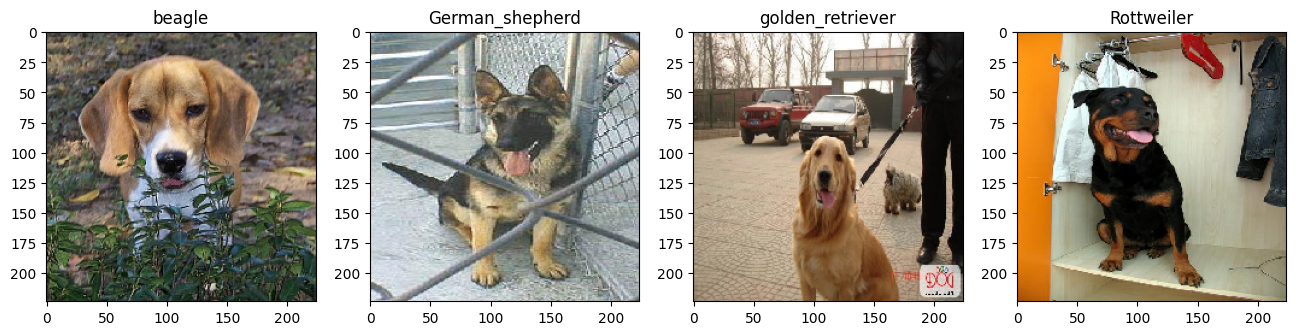

In [11]:
fig, ax = plt.subplots(ncols=4, figsize=(16,16))

for i in range(4):
    ax[i].set_title(breeds[i])
    ax[i].imshow(original[breeds[i]][61])

### 5. Loading the pre-trained ResNet50 model.

"ResNet stands for Residual Network and is a specific type of convolutional neural network (CNN) introduced in the 2015 paper “Deep Residual Learning for Image Recognition” by He Kaiming, Zhang Xiangyu, Ren Shaoqing, and Sun Jian. CNNs are commonly used to power computer vision applications.

ResNet-50 is a 50-layer convolutional neural network (48 convolutional layers, one MaxPool layer, and one average pool layer). Residual neural networks are a type of artificial neural network (ANN) that forms networks by stacking residual blocks."

reference: https://datagen.tech/guides/computer-vision/resnet-50/

In [12]:
model = ResNet50(weights='imagenet')

### 6. Preprocessing the original images according to the ResNet50 input shape and getting the predictions.

In [13]:
original_pp = pre_process_images(original)

In [14]:
predictions_original = predict_ResNet50(original_pp)

### 7. Building DataFrame with results for the original images and visualising.

In [15]:
original_df = build_dataframe(predictions_original)
original_df

,true_class_score,true_class,predicted_class_score,predicted_class
0,0.855182,beagle,0.855182,beagle
1,0.898487,beagle,0.898487,beagle
2,0.740433,beagle,0.740433,beagle
3,0.773031,beagle,0.773031,beagle
4,0.861379,beagle,0.861379,beagle
...,...,...,...,...
583,0.993223,Rottweiler,0.993223,Rottweiler
584,0.761421,Rottweiler,0.761421,Rottweiler
585,0.629020,Rottweiler,0.629020,Rottweiler
586,0.786985,Rottweiler,0.786985,Rottweiler


#### The ResNet50 scores distribution for the true (expected) classes

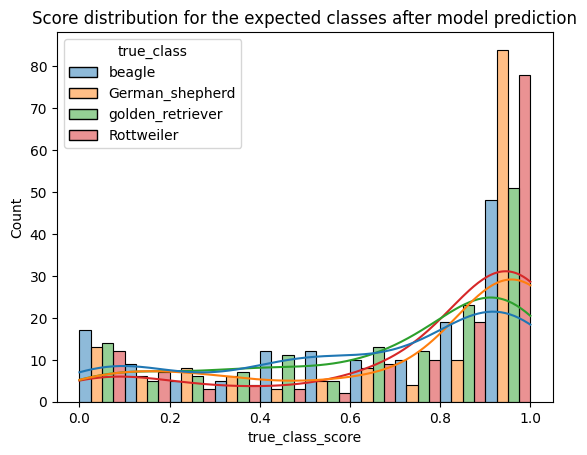

In [16]:
sns.histplot(data=original_df, x="true_class_score", bins=10, kde=True, hue='true_class', multiple="dodge")

plt.title("Score distribution for the expected classes after model prediction")
plt.show()

#### Total of 126 out of 588 cases where the classes were misclassified by ResNet50.

In [17]:
wrong_pred = original_df[original_df.true_class != original_df.predicted_class].reset_index(drop=True)
wrong_pred.shape

(126, 4)

The majority of the scores in the misclassification are in the interval (0, 0.1).

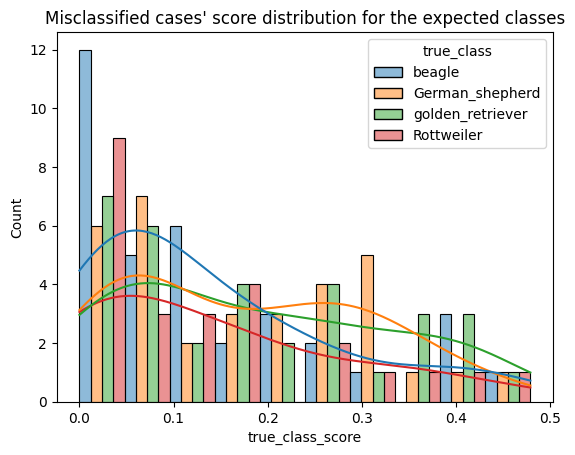

In [18]:
sns.histplot(data=wrong_pred, x="true_class_score", bins=10, kde=True, hue='true_class', multiple="dodge")

plt.title("Misclassified cases' score distribution for the expected classes")
plt.show()

#### The true class score distribution for the beagle original images.

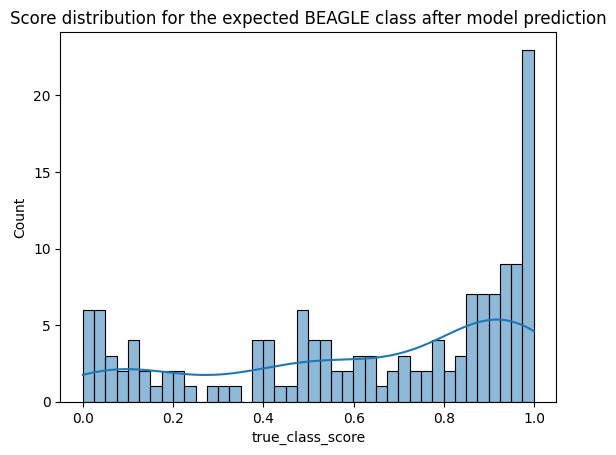

In [19]:
original_beagles = original_df[original_df.true_class == 'beagle']
sns.histplot(data=original_beagles, x="true_class_score", bins=40, kde=True)

plt.title("Score distribution for the expected BEAGLE class after model prediction")
plt.show()

#### For the total amount of 35 misclassified cases, the tendency curve for the true score distribution is similar to the one described for the total of the 126 mispredicted cases.

In [20]:
wrong_pred_beagles = original_beagles[original_beagles.predicted_class != 'beagle']
wrong_pred_beagles.shape

(35, 4)

The scores for the true class in the mispredicted cases are all in the interval (0, 0.5).

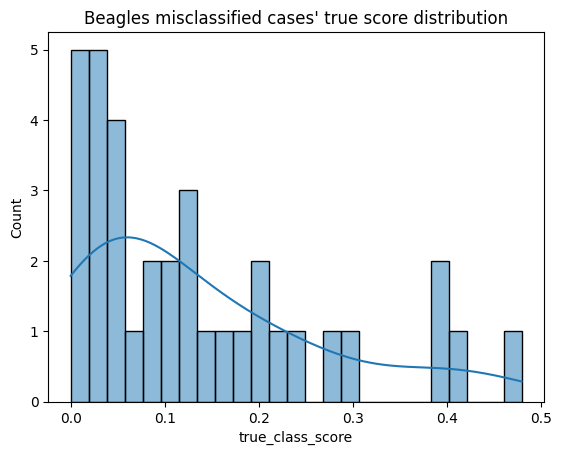

In [21]:
sns.histplot(data=wrong_pred_beagles, x="true_class_score", bins=25, kde=True)

plt.title("Beagles misclassified cases' true score distribution")
plt.show()

### 8. Applying K-Means unsupervised learning algorithm to compress all original images.

The fewer the clusters, the fewer the colors. After applying K-Means, the image pixels have their values assigned to a limited amount of value intensities that varies with tue number of clusters used by the algorithm. A two-clustered compression must define only two values of intensity for every pixel of the image.

In [22]:
original_ppc = pre_process_compression()

#### Compressing the original images considering three scenarios: 16, 8 and 4 clusters.

In [23]:
sixteen_compressed = compress_imgs_kmeans(16)
eight_compressed = compress_imgs_kmeans(8)
four_compressed = compress_imgs_kmeans(4)

#### The same photos visualised previously, now k-clustered compressed.

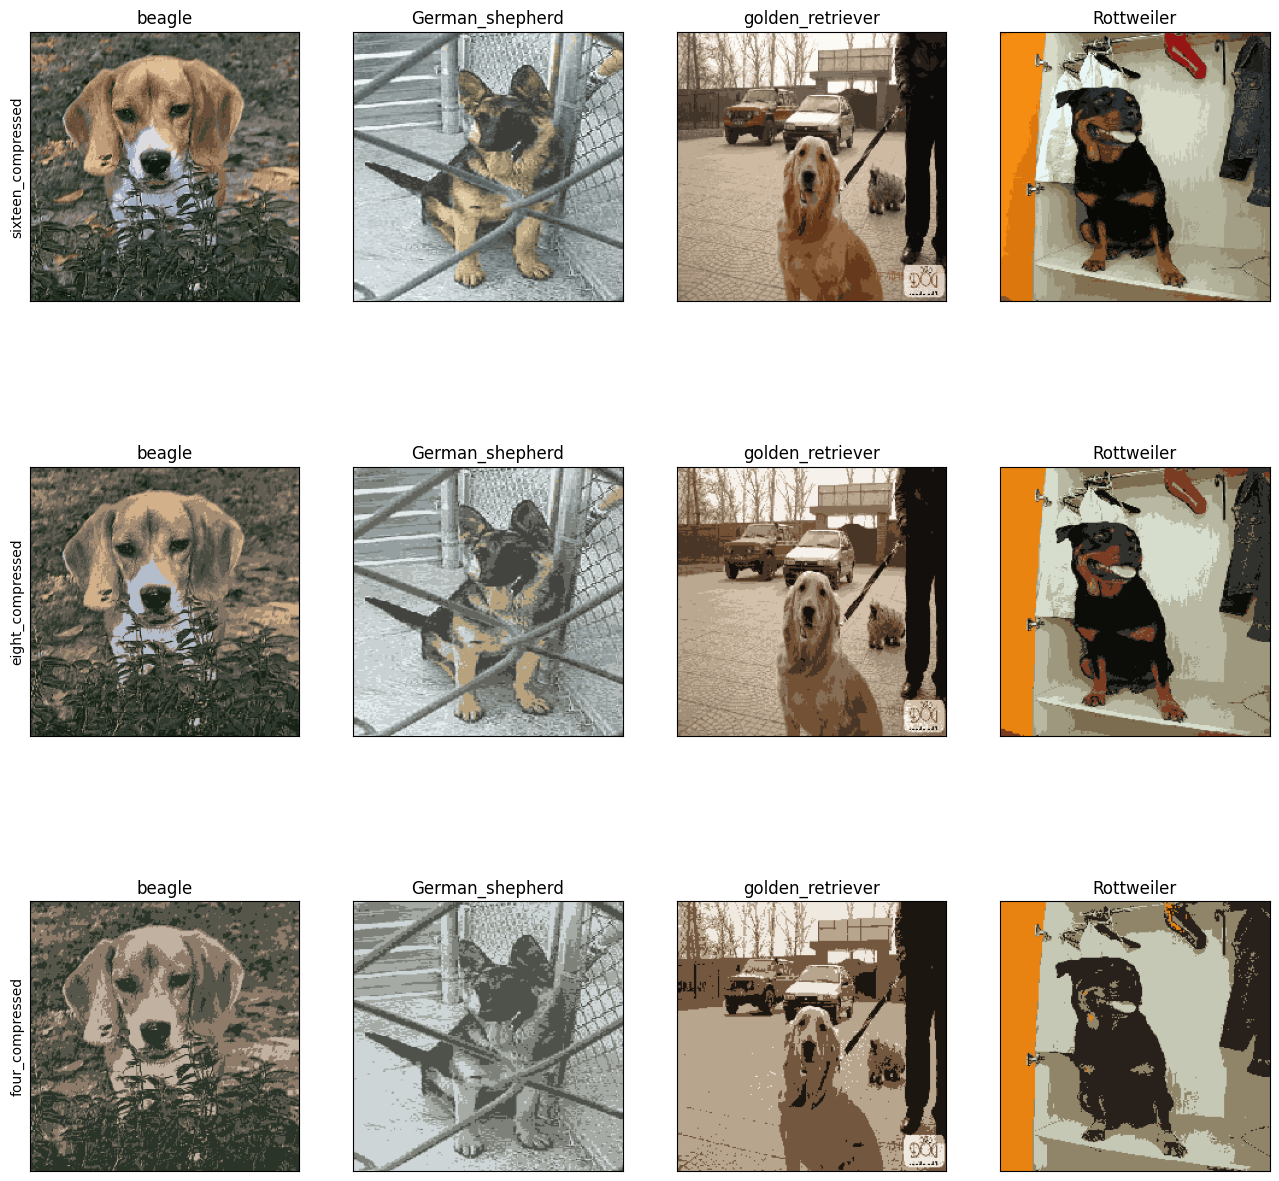

In [24]:
fig, ax = plt.subplots(nrows=3, ncols=4, figsize=(16,16))
compressed_imgs = [sixteen_compressed, eight_compressed, four_compressed]
ylabels = ['sixteen_compressed', 'eight_compressed', 'four_compressed']

for i in range(3):
    for j in range(4):
        ax[i][j].set_xticks([])
        ax[i][j].set_yticks([])
        ax[i][0].set_ylabel(ylabels[i])
        ax[i][j].set_title(breeds[j])
        ax[i][j].imshow(compressed_imgs[i][breeds[j]][61])

### 9. Feeding the compressed images to ResNet50 in order to analyse the influences on prediction scores.

In [25]:
sixteen_compressed_pp = pre_process_images(sixteen_compressed)
eight_compressed_pp = pre_process_images(eight_compressed)
four_compressed_pp = pre_process_images(four_compressed)

In [26]:
preds_sixteen_compressed = predict_ResNet50(sixteen_compressed_pp)
preds_eight_compressed = predict_ResNet50(eight_compressed_pp)
preds_four_compressed = predict_ResNet50(four_compressed_pp)

In [27]:
sixteen_compressed = build_dataframe(preds_sixteen_compressed)
eight_compressed = build_dataframe(preds_eight_compressed)
four_compressed = build_dataframe(preds_four_compressed)

#### How is the true class score distribution affected by image compression?

The plots show clearly that the fewer the clusters (the more compressed the image is), the fewer are the amount of higher scores for the expected class.

Analysing the graphics, it is possible to understand that the scores predictions for the expected class are being concentrated in the interval (0, 0.2). In other words, the ResNet50 is failing to correctly classify the images the more compressed they are.

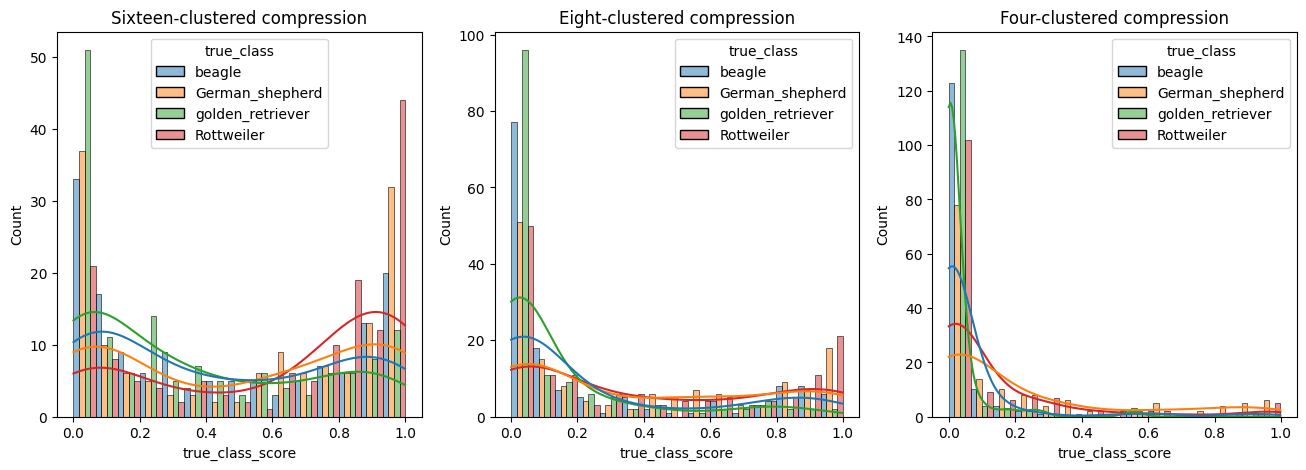

In [28]:
fig, ax = plt.subplots(ncols=3, figsize=(16,5))

sns.histplot(data=sixteen_compressed, x="true_class_score", bins=15, kde=True, hue='true_class', multiple="dodge", ax=ax[0])
sns.histplot(data=eight_compressed, x="true_class_score", bins=15, kde=True, hue='true_class', multiple="dodge", ax=ax[1])
sns.histplot(data=four_compressed, x="true_class_score", bins=15, kde=True, hue='true_class', multiple="dodge", ax=ax[2])

ax[0].set_title('Sixteen-clustered compression')
ax[1].set_title('Eight-clustered compression')
ax[2].set_title('Four-clustered compression')
plt.show()

#### How are the true class scores distributed considering the compressions and only the cases mispredicted?

These plots show only the cases that were misclassified by ResNet50.

Looking only at the KDE curves, the more compressed are the images (with fewer clusters), the greater is the KDEs derivatives in the score interval (0, 0.1). This indicates a tendency of very poor prediction while increasing the compression intensity. 

In [29]:
wrong_sixteen = sixteen_compressed[sixteen_compressed.true_class != sixteen_compressed.predicted_class].reset_index(drop=True)
wrong_eight   = eight_compressed[eight_compressed.true_class != eight_compressed.predicted_class].reset_index(drop=True)
wrong_four    = four_compressed[four_compressed.true_class != four_compressed.predicted_class].reset_index(drop=True)

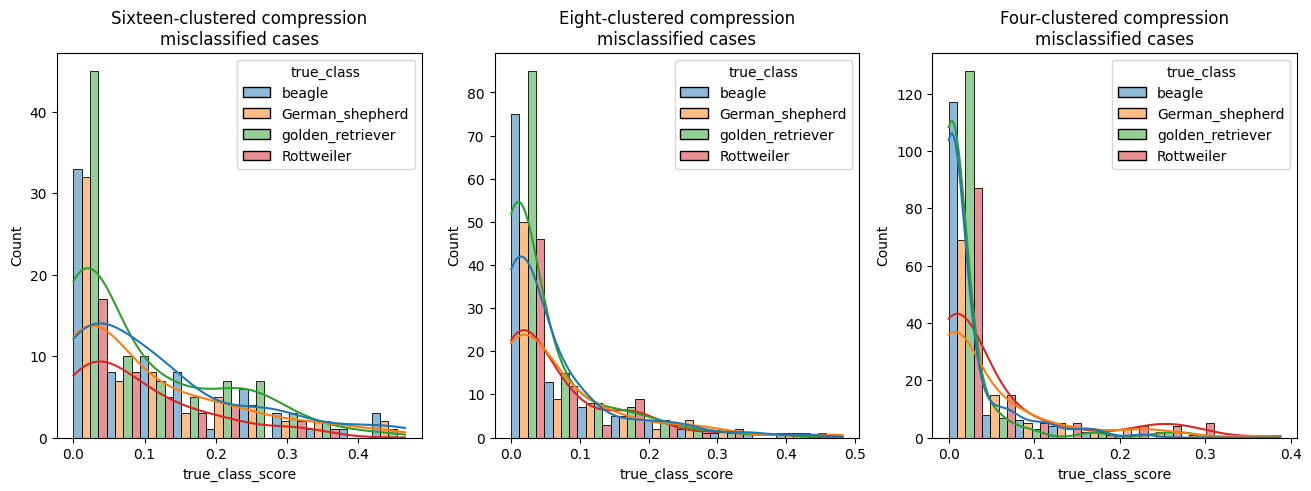

In [30]:
fig, ax = plt.subplots(ncols=3, figsize=(16,5))

sns.histplot(data=wrong_sixteen, x="true_class_score", bins=10, kde=True, hue='true_class', multiple="dodge", ax=ax[0])
sns.histplot(data=wrong_eight, x="true_class_score", bins=10, kde=True, hue='true_class', multiple="dodge", ax=ax[1])
sns.histplot(data=wrong_four, x="true_class_score", bins=10, kde=True, hue='true_class', multiple="dodge", ax=ax[2])

ax[0].set_title('Sixteen-clustered compression\nmisclassified cases')
ax[1].set_title('Eight-clustered compression\nmisclassified cases')
ax[2].set_title('Four-clustered compression\nmisclassified cases')
plt.show()

### 10. The ResNet50 accuracies considering these 4 scenarios: 
 <li>original images</li>
 <li>sixteen-clustered compressed images</li>
 <li>eight-clustered compressed images</li>
 <li>four-clustered compressed images</li>

In [31]:
original_acc = 1 - (wrong_pred.shape[0] / 588)
sixteen_acc = 1 - (wrong_sixteen.shape[0] / 588)
eight_acc = 1 - (wrong_eight.shape[0] / 588)
four_acc = 1 - (wrong_four.shape[0] / 588)

In [32]:
print("ResNet correct classification percentage under original images:", round(original_acc * 100, 2), "%")
print("ResNet correct classification percentage under sixteen-clustered compressed images: ", round(sixteen_acc * 100, 2), "%")
print("ResNet correct classification percentage under eight-clustered compressed images: ", round(eight_acc * 100, 2), "%")
print("ResNet correct classification percentage under four-clustered compressed images: ", round(four_acc * 100, 2), "%")

ResNet correct classification percentage under original images: 78.57 %
ResNet correct classification percentage under sixteen-clustered compressed images:  54.76 %
ResNet correct classification percentage under eight-clustered compressed images:  33.5 %
ResNet correct classification percentage under four-clustered compressed images:  13.1 %


In [33]:
acc = pd.DataFrame([[original_acc, 'Original image'], [sixteen_acc, 'Sixteen'], [eight_acc, 'Eight'], [four_acc, 'Four']])

In [34]:
acc.columns = ['Accuracy', 'Clusters']

In [35]:
acc

,Accuracy,Clusters
0,0.785714,Original image
1,0.547619,Sixteen
2,0.335034,Eight
3,0.130952,Four


#### We can clearly see how impactful is image compression for ResNet50 performance. The more compressed the images, the lower is the percentage of correct predictions.

It is also important to highlight that the accuracy always decreases with the decreasing of number of clusters when applying K-Means. The performance of ResNet50 always gets worse when intensifying image compression.

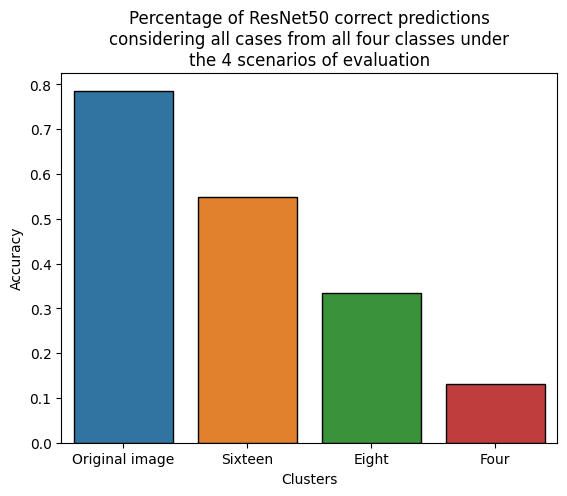

In [36]:
sns.barplot(data=acc, x="Clusters", y="Accuracy", edgecolor='black')

plt.title("Percentage of ResNet50 correct predictions\nconsidering all cases from all four classes under\nthe 4 scenarios of evaluation")
plt.show()